<a href="https://colab.research.google.com/github/sher1w/Regional-Fake-News-Models/blob/main/sarvam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📂 Loading and sampling data...
✅ Ready with 5000 samples.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

🚀 Starting training...


config.json:   0%|          | 0.00/717 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.77G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/279M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at sarvamai/sarvam-1 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-197423652.py:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling check

Step,Training Loss,Validation Loss,Accuracy,F1
50,7.411100,0.636450,0.700000,0.664430
100,2.247500,0.466880,0.794000,0.728947
150,1.722000,0.405229,0.843000,0.803995
200,1.778900,0.369077,0.853000,0.823529
250,1.299600,0.362017,0.841000,0.821948
300,0.938500,0.320074,0.868000,0.844340
350,1.114000,0.353990,0.856000,0.840000
400,0.865200,0.320947,0.875000,0.851720
450,1.148700,0.336120,0.860000,0.841629
500,0.873400,0.313721,0.876000,0.852029


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentra


🏆 Final Results: {'eval_loss': 0.31372079253196716, 'eval_accuracy': 0.876, 'eval_f1': 0.8520286396181385, 'eval_runtime': 66.238, 'eval_samples_per_second': 15.097, 'eval_steps_per_second': 3.774, 'epoch': 2.0}


/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


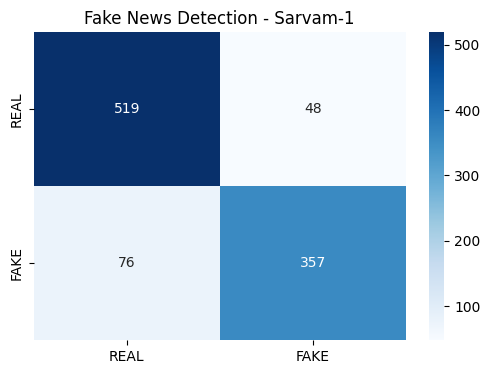

💾 Model saved to ./final_sarvam_model


/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Demo: 'RBI announces new policy' -> REAL


In [4]:
# ===================== 1. INSTALL DEPENDENCIES =====================
!pip install -qU transformers datasets peft accelerate bitsandbytes scikit-learn matplotlib seaborn

# ===================== 2. IMPORTS =====================
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# ===================== 3. CONFIGURATION (TIME OPTIMIZED) =====================
MODEL_NAME = "sarvamai/sarvam-1"
NUM_LABELS = 2
MAX_LEN = 128        # Shorter sequences = 2x faster training
SEED = 42
BATCH_SIZE = 4       # Better GPU utilization for T4
GRAD_ACCUM = 4       # Effective batch size of 16
SAMPLE_SIZE = 5000   # Limit to 5k rows to ensure < 1 hour completion

torch.manual_seed(SEED)
np.random.seed(SEED)

# ===================== 4. DATA LOADING & SAMPLING =====================
print("📂 Loading and sampling data...")
df = pd.read_csv("final_cleaned_data.csv")
df = df[["Text", "Label"]].dropna()
df["Text"] = df["Text"].astype(str).str.strip()
df = df[df["Text"] != ""]
df["Label"] = df["Label"].astype(int)

# Sample to ensure the 2-hour window is met
if len(df) > SAMPLE_SIZE:
    df = df.sample(n=SAMPLE_SIZE, random_state=SEED).reset_index(drop=True)

print(f"✅ Ready with {len(df)} samples.")

# ===================== 5. TOKENIZATION =====================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def tokenize(batch):
    return tokenizer(batch["Text"], padding="max_length", truncation=True, max_length=MAX_LEN)

# Prepare Dataset
dataset = Dataset.from_pandas(df).shuffle(seed=SEED)
dataset = dataset.train_test_split(test_size=0.2, seed=SEED)

train_ds = dataset["train"].map(tokenize, batched=True, remove_columns=["Text"])
eval_ds = dataset["test"].map(tokenize, batched=True, remove_columns=["Text"])

train_ds = train_ds.rename_column("Label", "labels")
eval_ds = eval_ds.rename_column("Label", "labels")
train_ds.set_format("torch")
eval_ds.set_format("torch")

# ===================== 6. MODEL SETUP (LoRA + 8-bit) =====================
def create_model():
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS,
        device_map="auto",
        load_in_8bit=True,
        trust_remote_code=True
    )
    model = prepare_model_for_kbit_training(model)

    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
        lora_dropout=0.1,
        bias="none",
        task_type="SEQ_CLS"
    )
    return get_peft_model(model, lora_config)

# ===================== 7. METRICS & TRAINING ARGS =====================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": accuracy_score(labels, preds), "f1": f1}

training_args = TrainingArguments(
    output_dir="./sarvam_fast_results",
    eval_strategy="steps",          # Eval every X steps for Early Stopping
    eval_steps=50,                  # Check performance frequently
    logging_steps=50,
    save_strategy="steps",
    save_steps=50,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUM,
    num_train_epochs=2,             # 2 epochs is enough for high-quality LLMs
    learning_rate=3e-4,
    fp16=True,
    load_best_model_at_end=True,    # Required for EarlyStopping
    metric_for_best_model="f1",
    save_total_limit=1,             # Save disk space
    report_to="none"
)

# ===================== 8. TRAIN WITH EARLY STOPPING =====================
print("🚀 Starting training...")
model = create_model()
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] # Stop if no improvement for 150 steps
)

trainer.train()

# ===================== 9. FINAL EVALUATION & PLOTS =====================
results = trainer.evaluate()
print(f"\n🏆 Final Results: {results}")

# Confusion Matrix
preds = trainer.predict(eval_ds)
y_pred = np.argmax(preds.predictions, axis=1)
cm = confusion_matrix(eval_ds["labels"], y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["REAL", "FAKE"], yticklabels=["REAL", "FAKE"])
plt.title("Fake News Detection - Sarvam-1")
plt.show()

# ===================== 10. SAVE & DEMO =====================
model.save_pretrained("./final_sarvam_model")
print("💾 Model saved to ./final_sarvam_model")

def quick_test(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=MAX_LEN).to("cuda")
    with torch.no_grad():
        logits = model(**inputs).logits
        pred = torch.argmax(logits, dim=-1).item()
    return "FAKE" if pred == 1 else "REAL"

print(f"Demo: 'RBI announces new policy' -> {quick_test('RBI announces new policy')}")

In [1]:
!pip install -U bitsandbytes accelerate transformers datasets peft scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [2]:
import torch
import bitsandbytes as bnb

print("GPU available:", torch.cuda.is_available())
print("bitsandbytes version:", bnb.__version__)


GPU available: True
bitsandbytes version: 0.49.0
